In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/pdc_dataset_with_target.csv')
print(df.shape)
df.head()

(41000, 8)


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,target
0,27.75,55.0,B,875.98,No,8,44.16,0
1,31.33,39.0,C,839.91,No,4,13.93,1
2,23.87,10.0,A,1364.70,Yes,4,15.16,0
3,35.64,34.0,C,1462.07,No,4,15.71,1
4,NaN,NaN,C,710.61,No,8,13.77,1


In [4]:
df.isna().sum()

,0
feature_1,2054
feature_2,2050
feature_3,0
feature_4,2054
feature_5,0
feature_6,0
feature_7,2036
target,0


In [5]:
df.describe()

,feature_1,feature_2,feature_4,feature_6,feature_7,target
count,38946.000000,38950.000000,38946.000000,41000.000000,38964.000000,41000.000000
mean,29.990843,49.436560,1092.312002,5.010732,23.145819,0.398000
std,5.000959,28.963859,1012.051699,2.582285,47.562436,0.489491
min,7.670000,0.000000,-155.620000,1.000000,0.000000,0.000000
25%,26.600000,25.000000,801.150000,3.000000,5.830000,0.000000
50%,30.000000,49.000000,1004.735000,5.000000,14.180000,0.000000
75%,33.390000,75.000000,1208.140000,7.000000,28.370000,1.000000
max,52.400000,99.000000,17643.400000,9.000000,1660.800000,1.000000


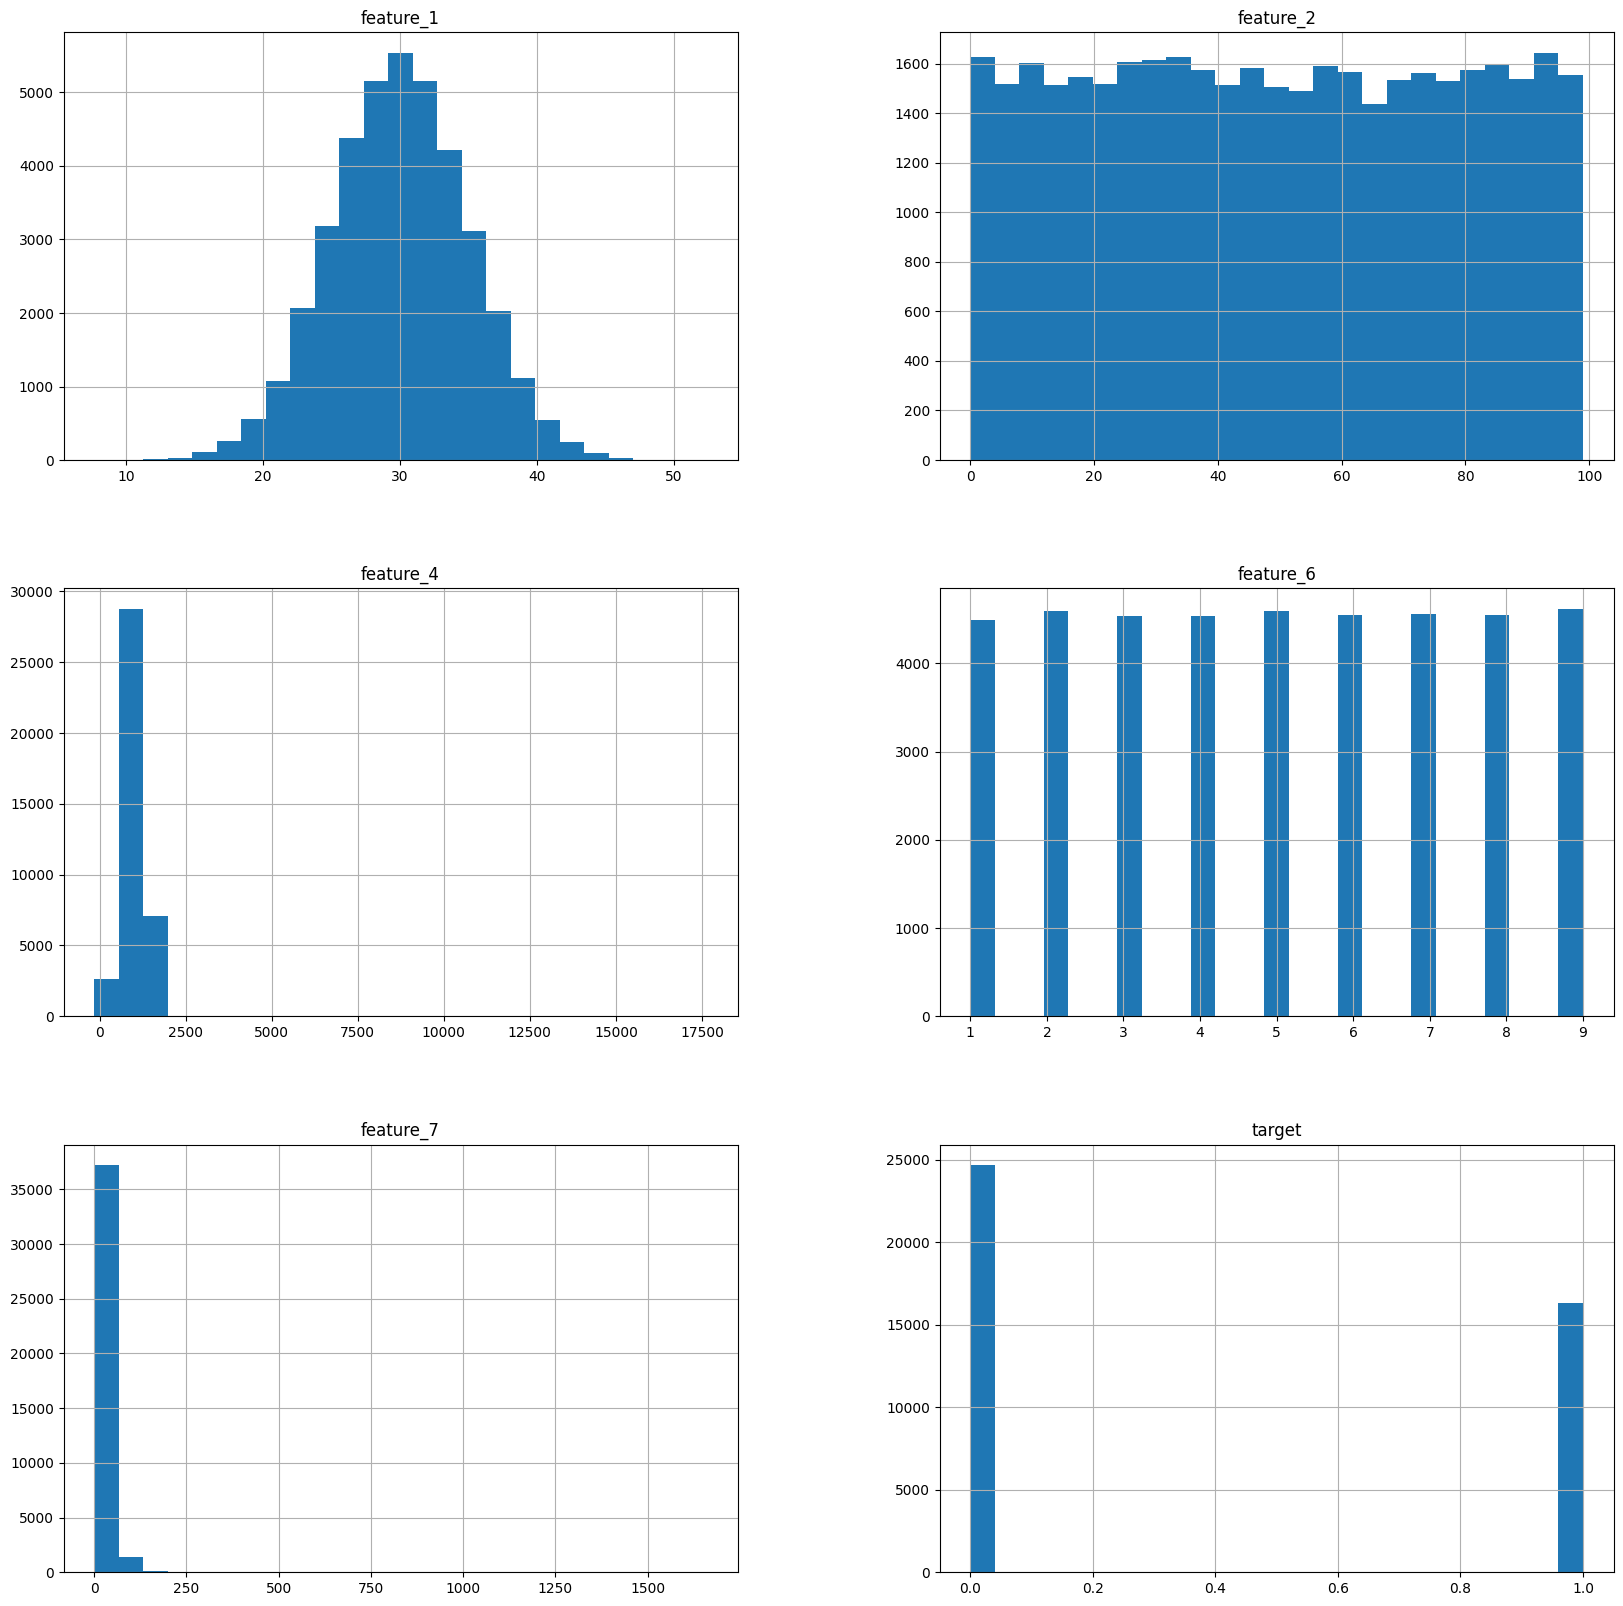

In [5]:
# Histogram of the each feature
df.hist(figsize=(20, 20), bins=25)
plt.show()

## Filling the missing values

- feature_1 and feature_2 are not much skewed so filling them with mean is suitable
- feature_4 and feature_7 should be filled with median

In [6]:
df.fillna({
    'feature_1': df['feature_1'].mean(),
    'feature_2': df['feature_2'].mean(),
    'feature_4': df['feature_4'].median(),
    'feature_7': df['feature_7'].median()
}, inplace=True)

In [7]:
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,target
0,27.750000,55.00000,B,875.98,No,8,44.16,0
1,31.330000,39.00000,C,839.91,No,4,13.93,1
2,23.870000,10.00000,A,1364.70,Yes,4,15.16,0
3,35.640000,34.00000,C,1462.07,No,4,15.71,1
4,29.990843,49.43656,C,710.61,No,8,13.77,1


In [ ]:
df['feature_3'].value_counts()

feature_3
A    13704
C    13680
B    13616
Name: count, dtype: int64

In [ ]:
df['feature_5'].value_counts()

feature_5
Yes    20519
No     20481
Name: count, dtype: int64

In [ ]:
df['feature_6'].value_counts()

feature_6
9    4618
5    4589
2    4587
7    4556
8    4547
6    4543
4    4537
3    4531
1    4492
Name: count, dtype: int64

In [ ]:
df['target'].value_counts()

target
0    24682
1    16318
Name: count, dtype: int64

In [ ]:
df.dtypes

feature_1    float64
feature_2    float64
feature_3     object
feature_4    float64
feature_5     object
feature_6      int64
feature_7    float64
target         int64
dtype: object

First of all, let the categorical features be encoded

In [7]:
X = df.drop(columns=['target'])
y = df['target']

X_train_not_resampled, X_test, y_train_not_resampled, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train_not_resampled[['feature_3', 'feature_5', 'feature_6']])
X_test_ohe = ohe.transform(X_test[['feature_3', 'feature_5', 'feature_6']])

qtr = QuantileTransformer()
X_train_qtr = qtr.fit_transform(X_train_not_resampled[['feature_1', 'feature_2', 'feature_4', 'feature_7']])
X_test_qtr = qtr.transform(X_test[['feature_1', 'feature_2', 'feature_4', 'feature_7']])

X_train_scaled_not_resampled = np.concatenate([X_train_qtr, X_train_ohe], axis=1)
X_test = np.concatenate([X_test_qtr, X_test_ohe], axis=1)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_scaled_not_resampled, y_train_not_resampled)

print(X_train_scaled_not_resampled.shape)
print(X_train.shape)
print(X_test.shape)

(30750, 18)
(36990, 18)
(10250, 18)


In [8]:
print("Training XGBoost Models...")

# --- XGBoost Serial
start_time = time.time()
xgb_serial = xgb.XGBClassifier(n_jobs=1, use_label_encoder=False, eval_metric='auc')
xgb_serial.fit(X_train, y_train)
serial_time = time.time() - start_time

# --- XGBoost Parallel CPU
start_time = time.time()
xgb_parallel = xgb.XGBClassifier(n_jobs=-1, use_label_encoder=False, eval_metric='auc')
xgb_parallel.fit(X_train, y_train)
parallel_time = time.time() - start_time

# --- XGBoost GPU
start_time = time.time()
xgb_gpu = xgb.XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False, eval_metric='auc')
xgb_gpu.fit(X_train, y_train)
gpu_time = time.time() - start_time

Training XGBoost Models...


In [9]:
# building a deep learning pipeline and optimize it with Optimize the pipeline using one or more of the following: Parallel computing (multithreading, multiprocessing)
#  GPU acceleration (PyTorch, CUDA)

# Prepare datasets
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

# Define model
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),  # Output logits
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

# Class imbalance handling
class_counts = y_train.value_counts()
pos_weight_cpu = torch.tensor([class_counts[0] / class_counts[1]], device='cpu')  # for CPU
pos_weight_gpu = torch.tensor([class_counts[0] / class_counts[1]], device='cuda')  # for GPU

# ---------- CPU Training ----------
model_cpu = BinaryClassifier(X_train.shape[1]).to('cpu')
criterion_cpu = nn.BCELoss()
optimizer_cpu = optim.Adam(model_cpu.parameters(), lr=0.001)

start_time = time.time()
epochs = 50

for epoch in range(epochs):
    model_cpu.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        outputs = model_cpu(batch_X)
        loss = criterion_cpu(outputs, batch_y)
        optimizer_cpu.zero_grad()
        loss.backward()
        optimizer_cpu.step()
        running_loss += loss.item()
    print(f'CPU Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

cpu_train_time = time.time() - start_time


CPU Epoch 1/50, Loss: 0.6934
CPU Epoch 2/50, Loss: 0.6931
CPU Epoch 3/50, Loss: 0.6931
CPU Epoch 4/50, Loss: 0.6928
CPU Epoch 5/50, Loss: 0.6926
CPU Epoch 6/50, Loss: 0.6924
CPU Epoch 7/50, Loss: 0.6922
CPU Epoch 8/50, Loss: 0.6919
CPU Epoch 9/50, Loss: 0.6916
CPU Epoch 10/50, Loss: 0.6911
CPU Epoch 11/50, Loss: 0.6907
CPU Epoch 12/50, Loss: 0.6903
CPU Epoch 13/50, Loss: 0.6898
CPU Epoch 14/50, Loss: 0.6894
CPU Epoch 15/50, Loss: 0.6889
CPU Epoch 16/50, Loss: 0.6884
CPU Epoch 17/50, Loss: 0.6876
CPU Epoch 18/50, Loss: 0.6871
CPU Epoch 19/50, Loss: 0.6866
CPU Epoch 20/50, Loss: 0.6858
CPU Epoch 21/50, Loss: 0.6855
CPU Epoch 22/50, Loss: 0.6847
CPU Epoch 23/50, Loss: 0.6840
CPU Epoch 24/50, Loss: 0.6835
CPU Epoch 25/50, Loss: 0.6826
CPU Epoch 26/50, Loss: 0.6818
CPU Epoch 27/50, Loss: 0.6814
CPU Epoch 28/50, Loss: 0.6805
CPU Epoch 29/50, Loss: 0.6796
CPU Epoch 30/50, Loss: 0.6791
CPU Epoch 31/50, Loss: 0.6788
CPU Epoch 32/50, Loss: 0.6781
CPU Epoch 33/50, Loss: 0.6771
CPU Epoch 34/50, Lo

In [13]:
# ---------- GPU Training ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_gpu = BinaryClassifier(X_train.shape[1]).to(device)
criterion_gpu = nn.BCELoss()
optimizer_gpu = optim.Adam(model_gpu.parameters(), lr=0.001)

# Keep data on CPU for DataLoader
train_dataset_gpu = TensorDataset(X_train_tensor, y_train_tensor)
train_loader_gpu = DataLoader(train_dataset_gpu, batch_size=1024, shuffle=True, num_workers=8, pin_memory=True)

scaler = GradScaler()

start_time = time.time()

for epoch in range(epochs):
    model_gpu.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader_gpu:
        # Move batch to GPU inside the loop
        batch_X = batch_X.to(device, non_blocking=True)
        batch_y = batch_y.to(device, non_blocking=True)

        optimizer_gpu.zero_grad()
        #with autocast():
        outputs = model_gpu(batch_X)
        loss = criterion_gpu(outputs, batch_y)

        scaler.scale(loss).backward()
        scaler.step(optimizer_gpu)
        scaler.update()

        running_loss += loss.item()
    print(f'GPU Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader_gpu):.4f}')

gpu_train_time_nn = time.time() - start_time


GPU Epoch 1/50, Loss: 0.6936
GPU Epoch 2/50, Loss: 0.6932
GPU Epoch 3/50, Loss: 0.6930
GPU Epoch 4/50, Loss: 0.6929
GPU Epoch 5/50, Loss: 0.6928
GPU Epoch 6/50, Loss: 0.6926
GPU Epoch 7/50, Loss: 0.6925
GPU Epoch 8/50, Loss: 0.6923
GPU Epoch 9/50, Loss: 0.6922
GPU Epoch 10/50, Loss: 0.6921
GPU Epoch 11/50, Loss: 0.6919
GPU Epoch 12/50, Loss: 0.6917
GPU Epoch 13/50, Loss: 0.6917
GPU Epoch 14/50, Loss: 0.6914
GPU Epoch 15/50, Loss: 0.6915
GPU Epoch 16/50, Loss: 0.6911
GPU Epoch 17/50, Loss: 0.6908
GPU Epoch 18/50, Loss: 0.6911
GPU Epoch 19/50, Loss: 0.6905
GPU Epoch 20/50, Loss: 0.6902
GPU Epoch 21/50, Loss: 0.6901
GPU Epoch 22/50, Loss: 0.6900
GPU Epoch 23/50, Loss: 0.6896
GPU Epoch 24/50, Loss: 0.6892
GPU Epoch 25/50, Loss: 0.6890
GPU Epoch 26/50, Loss: 0.6888
GPU Epoch 27/50, Loss: 0.6887
GPU Epoch 28/50, Loss: 0.6888
GPU Epoch 29/50, Loss: 0.6882
GPU Epoch 30/50, Loss: 0.6885
GPU Epoch 31/50, Loss: 0.6884
GPU Epoch 32/50, Loss: 0.6883
GPU Epoch 33/50, Loss: 0.6876
GPU Epoch 34/50, Lo

In [14]:
def evaluate(model, X, y, framework="xgb"):
    if framework == "xgb":
        preds = model.predict(X)
    else:  # torch
        model.eval()
        with torch.no_grad():
            outputs = model(X)
            preds = (outputs > 0.5).float().cpu().numpy().astype(int)  # Threshold at 0.5
    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds)
    cm = confusion_matrix(y, preds)
    return acc, f1, cm

# Evaluate models
xgb_serial_results = evaluate(xgb_serial, X_test, y_test, framework="xgb")
xgb_parallel_results = evaluate(xgb_parallel, X_test, y_test, framework="xgb")
xgb_gpu_results = evaluate(xgb_gpu, X_test, y_test, framework="xgb")
pytorch_cpu_results = evaluate(model_cpu, X_test_tensor, y_test, framework="torch")
pytorch_gpu_results = evaluate(model_gpu, X_test_tensor.to(device), y_test, framework="torch")

# 6. Reporting
print("\n" + "="*40)
print("Model Evaluation Results")
print("="*40)
print(f"XGBoost Serial Training   ➔  Accuracy: {xgb_serial_results[0]:.4f} | F1-Score: {xgb_serial_results[1]:.4f} | Time: {serial_time:.2f} sec")
print(f"XGBoost Parallel (CPU)     ➔  Accuracy: {xgb_parallel_results[0]:.4f} | F1-Score: {xgb_parallel_results[1]:.4f} | Time: {parallel_time:.2f} sec")
print(f"XGBoost GPU Accelerated    ➔  Accuracy: {xgb_gpu_results[0]:.4f} | F1-Score: {xgb_gpu_results[1]:.4f} | Time: {gpu_time:.2f} sec")
print(f"PyTorch CPU Training       ➔  Accuracy: {pytorch_cpu_results[0]:.4f} | F1-Score: {pytorch_cpu_results[1]:.4f} | Time: {cpu_train_time:.2f} sec")
print(f"PyTorch GPU Accelerated    ➔  Accuracy: {pytorch_gpu_results[0]:.4f} | F1-Score: {pytorch_gpu_results[1]:.4f} | Time: {gpu_train_time_nn:.2f} sec")
print("="*40)



Model Evaluation Results
XGBoost Serial Training   ➔  Accuracy: 0.5245 | F1-Score: 0.4327 | Time: 0.61 sec
XGBoost Parallel (CPU)     ➔  Accuracy: 0.5245 | F1-Score: 0.4327 | Time: 0.38 sec
XGBoost GPU Accelerated    ➔  Accuracy: 0.5197 | F1-Score: 0.4321 | Time: 0.57 sec
PyTorch CPU Training       ➔  Accuracy: 0.5084 | F1-Score: 0.4513 | Time: 119.37 sec
PyTorch GPU Accelerated    ➔  Accuracy: 0.4898 | F1-Score: 0.4592 | Time: 37.34 sec


## Why GPU XGBoost is Not Faster Here
**Small Dataset Size:**
GPU benefits appear only with large datasets (typically 100,000+ samples). Small datasets cause overhead to dominate.

**Model Complexity:**
If trees are shallow and boosting rounds are low, CPU is already highly optimized and often faster.

**Kernel Launch Overhead:**
GPU needs to launch CUDA kernels for every task. For small jobs, this overhead becomes significant.

**Hardware Limitations:**
Kaggle GPUs like Tesla T4 or P100 are not extremely powerful compared to high-end CPUs.

**Data Movement Overhead:**
Even minimal CPU↔GPU data transfer causes noticeable delays for tiny datasets.

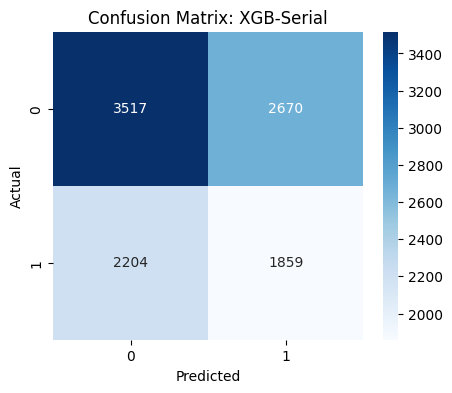

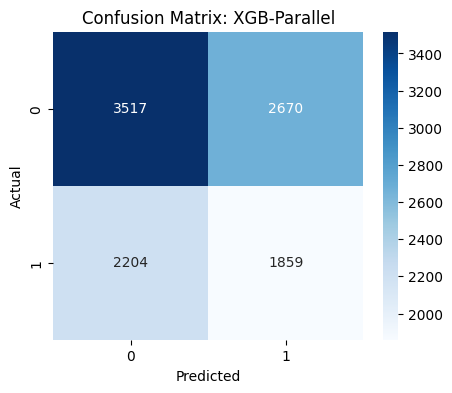

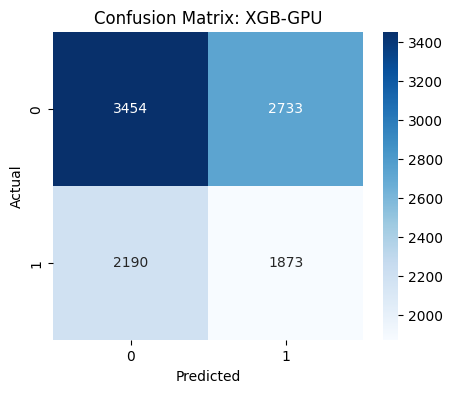

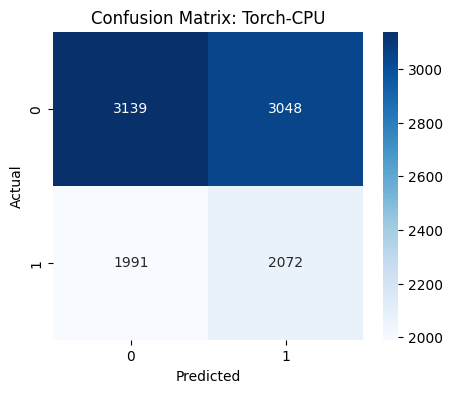

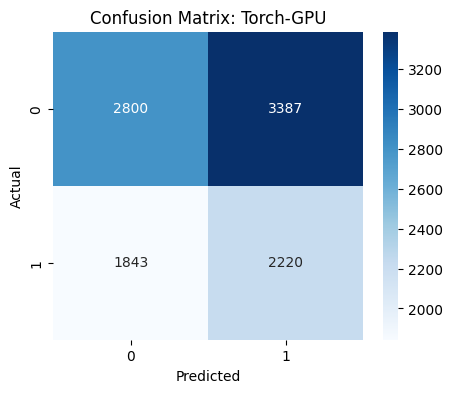

In [15]:
# 7. Confusion Matrix Plot
models = ['XGB-Serial', 'XGB-Parallel', 'XGB-GPU', 'Torch-CPU', 'Torch-GPU']
results = [xgb_serial_results, xgb_parallel_results, xgb_gpu_results, pytorch_cpu_results, pytorch_gpu_results]

for model_name, result in zip(models, results):
    plt.figure(figsize=(5,4))
    sns.heatmap(result[2], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# _______________________________________________________________-